<a href="https://colab.research.google.com/github/zia207/01_Generalized_Linear_Models_Python/blob/main/Notebook/02_01_10_04_regularized_glm_poisson_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 10.4 Regularized Poisson Regression Model

Regularized Poisson regression is a statistical modeling technique used to predict count data while addressing overfitting through regularization. Count data often follows a Poisson distribution, but standard Poisson regression can struggle with high-dimensional data or highly correlated predictors, leading to unstable estimates. Techniques like **ridge**, **lasso**, and **elastic net** add penalty terms to improve interpretability and accuracy. This tutorial introduces how to implement regularized Poisson regression in Python. We will first fit the model from scratch to understand the theory and then use `scikit-learn` and `statsmodels` to apply ridge, lasso, and elastic net Poisson regression. This approach provides theoretical insights and practical skills for applying regularized Poisson regression in various contexts, from academic research to industry applications.

## Overview

The **Regularized Poisson Regression Model** is a variant of Poisson regression used to model count data, where the goal is to estimate the relationship between a set of predictors and a count outcome (e.g., number of events). The regularization and the offset are additional components that refine the model and improve its performance, especially when dealing with complex or noisy data.

The componets Regularized Poisson Regression Model with offset:

1. **Poisson Regression**:

   - Poisson regression is a type of generalized linear model (GLM) where the outcome variable follows a Poisson distribution. It's commonly used for modeling count data (e.g., the number of occurrences of an event).
   - The Poisson distribution has the probability mass function:

 $$
 P(Y = y) = \frac{\lambda^y e^{-\lambda}}{y!}, \quad y = 0, 1, 2, \dots
 $$
   
   where $\lambda$ is the expected count (rate parameter), and $Y$ is the random variable representing the count.

   - The Poisson regression model assumes that:
     
 $$
 \log(\lambda) = \mathbf{X} \beta
 $$
     
   where $\lambda$ is the expected count, $\mathbf{X}$ is the matrix of predictor variables, and $\beta$ is the vector of coefficients to be estimated.

2. **Offset**:

The offset allows you to adjust for known exposure levels (such as time, area, or population size) that affect the count outcome but are not part of the predictors you want to estimate.

   - An **offset** is a known component in the model that is included in the linear predictor, but its coefficient is fixed (usually set to 1). This is often used when the scale of the response variable is affected by some external factor.
   - In a Poisson regression with an offset, the model becomes:
     
 $$
 \log(\lambda) = \mathbf{X} \beta + \text{offset}
 $$
     
 where the offset can be any known value or variable that is not estimated during the regression but is important for predicting the count outcome (e.g., the total time at risk, population size, or exposure rate).

3. **Regularization**:

Regularization helps avoid overfitting, especially in cases where there are many predictors or the model is complex, leading to more stable and interpretable coefficients.

   - **Regularization** refers to adding a penalty term to the loss function in order to prevent overfitting and improve the generalization of the model. For Poisson regression, regularization is typically done using either **L1** (Lasso) or **L2** (Ridge) regularization:

     - **L1 regularization** encourages sparsity in the model by penalizing the absolute values of the coefficients.

     - **L2 regularization** penalizes the squared values of the coefficients, shrinking them toward zero but generally not leading to exact zeros.
   
   The regularized Poisson regression model with an offset can be written as:
   
   $$
   \min_{\beta} \left( \sum_{i=1}^n \left( y_i \log(\lambda_i) - \lambda_i \right) + \text{Penalty}(\beta) \right)
   $$
   
   where $y_i$ is the observed count for the $i$-th observation, and $\lambda_i$ is the expected count, which depends on the predictors and the offset. The penalty term could represent either L1 or L2 regularization.

## Regularized Poisson Model from Scratch

Let's go through the process of fitting a Poisson model with an offset and predictors manually in Python. Here's the breakdown:

### Create a Data

For this example, we’ll simulate some count data, including four predictors and an offset variable.

In [ ]:
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(123)

n = 200  # Number of observations
p = 5    # Number of predictors

# Simulate predictors
X = np.random.randn(n, p)
feature_names = [f"X{i+1}" for i in range(p)]

# True coefficients
beta_true = np.array([0.5, -0.3, 0, 0.8, 0])

# Simulate offset and Poisson outcome
offset = np.log(np.random.uniform(1, 10, n))  # Offset variable
linear_predictor = X @ beta_true + offset
lambda_ = np.exp(linear_predictor)  # Poisson mean
Y = np.random.poisson(lambda_)  # Poisson-distributed response

# Combine data into a single dataframe
data = pd.DataFrame(X, columns=feature_names)
data['Y'] = Y
data['offset'] = offset

print("First 5 rows of simulated data:")
print(data.head())

First 5 rows of simulated data:
         X1        X2        X3        X4        X5   Y    offset
0 -1.085631  0.997345  0.282978 -1.506295 -0.578600   2  2.038604
1  1.651437 -2.426679 -0.428913  1.265936 -0.866740  33  0.964731
2 -0.678886 -0.094709  1.491390 -0.638902 -0.443982   0  1.097780
3 -0.434351  2.205930  2.186786  1.004054  0.386186   8  1.987639
4  0.737369  1.490732 -0.935834  1.175829 -1.253881  22  2.098084


### Regularized Poisson Regression Function

In [ ]:
def regularized_poisson(X, Y, offset, alpha, lambda_reg, max_iter=1000, tol=1e-6, learning_rate=0.01):
    """
    Fit regularized Poisson regression using gradient descent.

    Parameters:
    - X: predictor matrix (n x p)
    - Y: response vector (n,)
    - offset: offset vector (n,)
    - alpha: mixing parameter (0=Ridge, 1=Lasso, between=Elastic Net)
    - lambda_reg: regularization strength
    - max_iter: maximum iterations
    - tol: convergence tolerance
    - learning_rate: step size for gradient descent

    Returns:
    - beta: estimated coefficients
    """
    n, p = X.shape
    beta = np.zeros(p)  # Initialize coefficients

    for iter in range(max_iter):
        # Linear predictor
        eta = X @ beta + offset
        mu = np.exp(eta)  # Predicted Poisson mean

        # Gradient of the log-likelihood (without regularization)
        grad = X.T @ (Y - mu) / n

        # Add regularization gradient
        # For Elastic Net: alpha * L1 + (1-alpha) * L2
        l1_grad = alpha * np.sign(beta)
        l2_grad = 2 * (1 - alpha) * beta
        reg_grad = lambda_reg * (l1_grad + l2_grad)

        grad = grad - reg_grad

        # Update coefficients
        beta_new = beta + learning_rate * grad

        # Check for convergence
        if np.sum(np.abs(beta_new - beta)) < tol:
            print(f"Converged after {iter+1} iterations")
            break

        beta = beta_new

    return beta

### Cross-Validation Function

In [ ]:
from sklearn.model_selection import KFold

def cross_validate_poisson(X, Y, offset, alpha_values, lambda_values, n_folds=5):
    """
    Perform k-fold cross-validation for regularized Poisson regression.

    Returns:
    - results: DataFrame with alpha, lambda, and mean RMSE across folds
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    results = []

    for alpha in alpha_values:
        for lambda_reg in lambda_values:
            rmse_scores = []

            for train_idx, test_idx in kf.split(X):
                X_train, X_test = X[train_idx], X[test_idx]
                Y_train, Y_test = Y[train_idx], Y[test_idx]
                offset_train, offset_test = offset[train_idx], offset[test_idx]

                # Fit model
                beta = regularized_poisson(X_train, Y_train, offset_train, alpha, lambda_reg)

                # Predict on test set
                eta_test = X_test @ beta + offset_test
                mu_test = np.exp(eta_test)

                # Calculate RMSE
                rmse = np.sqrt(np.mean((Y_test - mu_test) ** 2))
                rmse_scores.append(rmse)

            mean_rmse = np.mean(rmse_scores)
            results.append({
                'alpha': alpha,
                'lambda': lambda_reg,
                'RMSE': mean_rmse
            })

    return pd.DataFrame(results)

### Cross-Validation Function

In [ ]:
# Define alpha and lambda values
alpha_values = [0, 0.5, 1]  # Ridge (0), Elastic Net (0.5), Lasso (1)
lambda_values = np.linspace(0.01, 1, 10)

# Cross-validate to find the best parameters
print("Performing cross-validation...")
cv_results = cross_validate_poisson(X, Y, offset, alpha_values, lambda_values)

# Display results
print("\nCross-validation results:")
print(cv_results.sort_values('RMSE').head(10))

# Best parameters for each model
ridge_results = cv_results[cv_results['alpha'] == 0]
lasso_results = cv_results[cv_results['alpha'] == 1]
elastic_net_results = cv_results[cv_results['alpha'] == 0.5]

ridge_best = ridge_results.loc[ridge_results['RMSE'].idxmin()]
lasso_best = lasso_results.loc[lasso_results['RMSE'].idxmin()]
elastic_net_best = elastic_net_results.loc[elastic_net_results['RMSE'].idxmin()]

print(f"\nBest Ridge parameters: alpha={ridge_best['alpha']}, lambda={ridge_best['lambda']:.4f}, RMSE={ridge_best['RMSE']:.4f}")
print(f"Best Lasso parameters: alpha={lasso_best['alpha']}, lambda={lasso_best['lambda']:.4f}, RMSE={lasso_best['RMSE']:.4f}")
print(f"Best Elastic Net parameters: alpha={elastic_net_best['alpha']}, lambda={elastic_net_best['lambda']:.4f}, RMSE={elastic_net_best['RMSE']:.4f}")

Performing cross-validation...
Converged after 134 iterations
Converged after 207 iterations
Converged after 153 iterations
Converged after 225 iterations
Converged after 142 iterations
Converged after 130 iterations
Converged after 200 iterations
Converged after 148 iterations
Converged after 215 iterations
Converged after 138 iterations
Converged after 127 iterations
Converged after 192 iterations
Converged after 144 iterations
Converged after 206 iterations
Converged after 134 iterations
Converged after 124 iterations
Converged after 185 iterations
Converged after 139 iterations
Converged after 197 iterations
Converged after 131 iterations
Converged after 120 iterations
Converged after 179 iterations
Converged after 135 iterations
Converged after 189 iterations
Converged after 127 iterations
Converged after 117 iterations
Converged after 173 iterations
Converged after 131 iterations
Converged after 182 iterations
Converged after 124 iterations
Converged after 115 iterations
Converge

### Fit ridge, lasso, and elastic net models

In [ ]:
# Fit final models with best parameters
print("\nFitting final models...")
ridge_model = regularized_poisson(X, Y, offset, ridge_best['alpha'], ridge_best['lambda'])
lasso_model = regularized_poisson(X, Y, offset, lasso_best['alpha'], lasso_best['lambda'])
elastic_net_model = regularized_poisson(X, Y, offset, elastic_net_best['alpha'], elastic_net_best['lambda'])

# Display coefficients
print("\nModel Coefficients:")
print(f"True coefficients: {beta_true}")
print(f"Ridge coefficients: {ridge_model}")
print(f"Lasso coefficients: {lasso_model}")
print(f"Elastic Net coefficients: {elastic_net_model}")


Fitting final models...
Converged after 151 iterations

Model Coefficients:
True coefficients: [ 0.5 -0.3  0.   0.8  0. ]
Ridge coefficients: [ 0.50084187 -0.29516101  0.00262859  0.77808148  0.00865502]
Lasso coefficients: [ 0.49364818 -0.28240921  0.00210926  0.79250614  0.0020425 ]
Elastic Net coefficients: [ 4.97591804e-01 -2.88590173e-01 -6.84951150e-04  7.85370033e-01
  4.18917113e-04]


### Evaluate Model Performance

In [ ]:
def evaluate_poisson_model(beta, X, Y, offset):
    """Evaluate model performance"""
    eta = X @ beta + offset
    mu = np.exp(eta)
    RMSE = np.sqrt(np.mean((Y - mu) ** 2))
    MAE = np.mean(np.abs(Y - mu))
    return {'RMSE': RMSE, 'MAE': MAE}

# Evaluate all models
ridge_perf = evaluate_poisson_model(ridge_model, X, Y, offset)
lasso_perf = evaluate_poisson_model(lasso_model, X, Y, offset)
elastic_net_perf = evaluate_poisson_model(elastic_net_model, X, Y, offset)

print("\nPerformance Metrics:")
print(f"Ridge: {ridge_perf}")
print(f"Lasso: {lasso_perf}")
print(f"Elastic Net: {elastic_net_perf}")

# Compare with true model
true_perf = evaluate_poisson_model(beta_true, X, Y, offset)
print(f"True Model: {true_perf}")


Performance Metrics:
Ridge: {'RMSE': np.float64(2.6462779051555674), 'MAE': np.float64(1.890442455699507)}
Lasso: {'RMSE': np.float64(2.6614709316655887), 'MAE': np.float64(1.9063484032646079)}
Elastic Net: {'RMSE': np.float64(2.6526014223686842), 'MAE': np.float64(1.8986528870906039)}
True Model: {'RMSE': np.float64(2.6392957177373155), 'MAE': np.float64(1.9197475794871257)}


## Regularized Poisson Model Using scikit-learn and statsmodels

Now let's implement the same analysis using established Python libraries. We'll use real-world data on diabetes prevalence.

In [ ]:
# Install required packages (uncomment if needed)
# !pip install pandas numpy scikit-learn statsmodels matplotlib seaborn requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import PoissonRegressor, SGDRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

print("Required packages imported successfully.")

Required packages imported successfully.


In [ ]:
# Load the county diabetes data
url = "https://raw.githubusercontent.com/zia207/Data/main/CSV_files/county_data_2016_2020.csv"
try:
    df = pd.read_csv(url)
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")
    # Create sample data if the URL doesn't work
    np.random.seed(42)
    n_samples = 1000
    df = pd.DataFrame({
        'Diabetes_per': np.random.poisson(8, n_samples),
        'Obesity': np.random.normal(30, 5, n_samples),
        'Physical_Inactivity': np.random.normal(25, 8, n_samples),
        'Access_Excercise': np.random.normal(70, 15, n_samples),
        'Food_Env_Index': np.random.uniform(3, 9, n_samples),
        'SVI': np.random.uniform(0, 1, n_samples),
        'Urban_Rural': np.random.choice(['Urban', 'Rural'], n_samples),
        'POP_Total': np.random.randint(10000, 500000, n_samples)
    })
    print("Sample data created.")

# Display basic information
print(f"\nDataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Basic statistics
print("\nBasic statistics:")
print(df.describe())

# Create log of population for offset
df['log_POP_Total'] = np.log(df['POP_Total'])

# Convert Urban_Rural to categorical
df['Urban_Rural'] = df['Urban_Rural'].astype('category')

print("\nData types:")
print(df.dtypes)

Data loaded successfully.

Dataset shape: (3107, 15)

First few rows:
   FIPS    State          County            X             Y  POP_Total  \
0  1001  Alabama  Autauga County  872679.1790  1.094433e+06    55707.0   
1  1003  Alabama  Baldwin County  789777.5039  8.845571e+05   218346.8   
2  1005  Alabama  Barbour County  997210.9974  1.033024e+06    25078.2   
3  1007  Alabama     Bibb County  822862.4715  1.141554e+06    22448.2   
4  1009  Alabama   Blount County  863725.1736  1.255735e+06    57852.4   

   Diabetes_count  Diabetes_per  Obesity  Access_Excercise  \
0            4282          9.24    29.22              70.8   
1           17477          8.48    28.94              72.2   
2            2659         11.72    29.34              49.8   
3            1966         10.08    29.44              30.6   
4            5318         10.26    30.10              24.6   

   Physical_Inactivity  PCP_rate  Food_Env_Index     SVI Urban_Rural  
0                26.42      44.8         

#### Split Data

We will use the `ddply()` function of the {plyr}  package to split soil carbon datainto homogeneous subgroups using **stratified random sampling**. This method involves dividing the population into strata and taking random samples from each stratum to ensure that each subgroup is proportionally represented in the sample. The goal is to obtain a representative sample of the population by adequately representing each stratum.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Create stratified split based on Urban_Rural
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=101)

for train_idx, test_idx in splitter.split(df, df['Urban_Rural']):
    train_df = df.iloc[train_idx].copy()
    test_df = df.iloc[test_idx].copy()

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# Verify stratification
print("\nUrban/Rural distribution in training set:")
print(train_df['Urban_Rural'].value_counts(normalize=True))
print("\nUrban/Rural distribution in test set:")
print(test_df['Urban_Rural'].value_counts(normalize=True))

Training set size: 2174
Test set size: 933

Urban/Rural distribution in training set:
Urban_Rural
Urban    0.578197
Rural    0.421803
Name: proportion, dtype: float64

Urban/Rural distribution in test set:
Urban_Rural
Urban    0.578778
Rural    0.421222
Name: proportion, dtype: float64


In [ ]:
# Define features and target
feature_columns = ['Obesity', 'Physical_Inactivity', 'Access_Excercise',
                  'Food_Env_Index', 'SVI', 'Urban_Rural']
target_column = 'Diabetes_per'
offset_column = 'log_POP_Total'

# Prepare training data
X_train = train_df[feature_columns]
y_train = train_df[target_column]
offset_train = train_df[offset_column]

# Prepare test data
X_test = test_df[feature_columns]
y_test = test_df[target_column]
offset_test = test_df[offset_column]

# Create preprocessing pipeline for categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['Obesity', 'Physical_Inactivity', 'Access_Excercise',
                               'Food_Env_Index', 'SVI']),
        ('cat', OneHotEncoder(drop='first'), ['Urban_Rural'])
    ],
    remainder='drop'
)

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after preprocessing
feature_names = (['Obesity', 'Physical_Inactivity', 'Access_Excercise',
                 'Food_Env_Index', 'SVI'] +
                [f'Urban_Rural_{cat}' for cat in preprocessor.named_transformers_['cat']
                 .categories_[0][1:]])

print(f"Processed feature matrix shape: {X_train_processed.shape}")
print(f"Feature names: {feature_names}")

Processed feature matrix shape: (2174, 6)
Feature names: ['Obesity', 'Physical_Inactivity', 'Access_Excercise', 'Food_Env_Index', 'SVI', 'Urban_Rural_Urban']


## Ridge Regression with scikit-learn

Note: scikit-learn's `PoissonRegressor` only supports L2 (Ridge) regularization.

In [ ]:
from sklearn.linear_model import PoissonRegressor

# Define parameter grid for Ridge regression
param_grid_ridge = {
    'alpha': np.logspace(-4, 1, 50)  # L2 regularization strength
}

# Create PoissonRegressor with Ridge penalty
ridge_poisson = PoissonRegressor(max_iter=1000, tol=1e-4)

# Perform cross-validation
cv_ridge = GridSearchCV(
    ridge_poisson,
    param_grid_ridge,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit with offset (using sample_weight for offset in Poisson regression)
# For Poisson regression with offset, we can use:
# log(μ) = Xβ + offset  =>  μ = exp(Xβ) * exp(offset)
# This is equivalent to using exp(offset) as sample_weight in the loss function
sample_weight_train = np.exp(offset_train)

cv_ridge.fit(X_train_processed, y_train, sample_weight=sample_weight_train)

print(f"Best Ridge alpha: {cv_ridge.best_params_['alpha']:.6f}")
print(f"Best Ridge CV score: {-cv_ridge.best_score_:.4f}")

# Fit final Ridge model
ridge_final = PoissonRegressor(
    alpha=cv_ridge.best_params_['alpha'],
    max_iter=1000
)
ridge_final.fit(X_train_processed, y_train, sample_weight=sample_weight_train)

# Display coefficients
ridge_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_final.coef_
})
print("\nRidge Regression Coefficients:")
print(ridge_coef)

# Make predictions
sample_weight_test = np.exp(offset_test)
y_pred_ridge = ridge_final.predict(X_test_processed)

# Since we used sample_weight for offset, we need to adjust predictions
# The model predicts rate per unit exposure, so multiply by exp(offset) for actual counts
y_pred_ridge_adjusted = y_pred_ridge * np.exp(offset_test - offset_train.mean())

print(f"\nRidge predictions (first 5): {y_pred_ridge_adjusted[:5]}")
print(f"Actual values (first 5): {y_test.values[:5]}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Ridge alpha: 0.000100
Best Ridge CV score: 0.6767

Ridge Regression Coefficients:
               Feature  Coefficient
0              Obesity     0.015656
1  Physical_Inactivity     0.014288
2     Access_Excercise     0.000267
3       Food_Env_Index    -0.021312
4                  SVI     0.134690
5    Urban_Rural_Urban     0.019265

Ridge predictions (first 5): 964      4.322037
1170    73.483866
2358     0.305901
2351     0.607761
128     17.367153
Name: log_POP_Total, dtype: float64
Actual values (first 5): [ 9.78  9.54  6.74  6.84 12.82]


## Lasso and Elastic Net with statsmodels

Since scikit-learn's PoissonRegressor doesn't support L1 regularization, we'll use statsmodels for Lasso and Elastic Net.

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# For statsmodels, we need to add a constant term
X_train_sm = sm.add_constant(pd.DataFrame(X_train_processed, columns=feature_names))
X_test_sm = sm.add_constant(pd.DataFrame(X_test_processed, columns=feature_names))

# Standardize features for better regularization performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm.iloc[:, 1:])  # exclude constant
X_test_scaled = scaler.transform(X_test_sm.iloc[:, 1:])

# Add constant back
X_train_scaled_sm = sm.add_constant(X_train_scaled)
X_test_scaled_sm = sm.add_constant(X_test_scaled)

# Update feature names
feature_names_sm = ['const'] + feature_names

print("Fitting Lasso Poisson Regression with statsmodels...")

# Lasso regression (L1 penalty)
# Note: statsmodels GLM with Lasso penalty
alpha_lasso = 0.1  # You can tune this parameter

# Fit Lasso Poisson model
lasso_model = sm.GLM(
    y_train,
    X_train_scaled_sm,
    family=sm.families.Poisson(),
    offset=offset_train
).fit_regularized(
    method='elastic_net',
    alpha=alpha_lasso,
    L1_wt=1.0  # L1_wt=1.0 means Lasso
)

print("Lasso Poisson Regression Results:")
#print(lasso_model.summary())

# Make predictions
y_pred_lasso = lasso_model.predict(X_test_scaled_sm, offset=offset_test)

print(f"\nLasso predictions (first 5): {y_pred_lasso[:5]}")
print(f"Actual values (first 5): {y_test.values[:5]}")

# Elastic Net regression
print("\nFitting Elastic Net Poisson Regression with statsmodels...")

alpha_elastic = 0.1  # Regularization strength
l1_ratio = 0.5       # Mix of L1 and L2 (0.5 = equal mix)

# Fit Elastic Net Poisson model
elastic_model = sm.GLM(
    y_train,
    X_train_scaled_sm,
    family=sm.families.Poisson(),
    offset=offset_train
).fit_regularized(
    method='elastic_net',
    alpha=alpha_elastic,
    L1_wt=l1_ratio
)

print("Elastic Net Poisson Regression Results:")
#print(elastic_model.summary())

# Make predictions
y_pred_elastic = elastic_model.predict(X_test_scaled_sm, offset=offset_test)

print(f"\nElastic Net predictions (first 5): {y_pred_elastic[:5]}")
print(f"Actual values (first 5): {y_test.values[:5]}")

Fitting Lasso Poisson Regression with statsmodels...
Lasso Poisson Regression Results:

Lasso predictions (first 5): 964      2.697868
1170    12.350731
2358     3.393771
2351     8.071309
128      6.582114
Name: log_POP_Total, dtype: float64
Actual values (first 5): [ 9.78  9.54  6.74  6.84 12.82]

Fitting Elastic Net Poisson Regression with statsmodels...
Elastic Net Poisson Regression Results:

Elastic Net predictions (first 5): 964      2.857474
1170    12.949018
2358     3.731338
2351     8.596893
128      6.937160
Name: log_POP_Total, dtype: float64
Actual values (first 5): [ 9.78  9.54  6.74  6.84 12.82]


## Model Performance Metrics

In [ ]:
def calculate_poisson_metrics(y_true, y_pred, model_name=""):
    """Calculate various metrics for Poisson regression"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    medae = np.median(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)

    metrics = {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'MedAE': medae,
        'R2': r2
    }
    return metrics

# Calculate metrics for all models
metrics_ridge = calculate_poisson_metrics(y_test, y_pred_ridge_adjusted, "Ridge")
metrics_lasso = calculate_poisson_metrics(y_test, y_pred_lasso, "Lasso")
metrics_elastic = calculate_poisson_metrics(y_test, y_pred_elastic, "Elastic Net")

# Create comparison DataFrame
metrics_df = pd.DataFrame([metrics_ridge, metrics_lasso, metrics_elastic])
print("Model Performance Comparison:")
print(metrics_df.round(4))

# Find best model based on RMSE
best_model_idx = metrics_df['RMSE'].idxmin()
best_model = metrics_df.loc[best_model_idx, 'Model']
print(f"\nBest model based on RMSE: {best_model}")

Model Performance Comparison:
         Model     RMSE      MAE        MSE   MedAE        R2
0        Ridge  87.9275  25.5665  7731.2415  5.8112 -3198.942
1        Lasso   8.9082   5.7577    79.3555  4.5199   -31.845
2  Elastic Net   9.2974   5.9000    86.4417  4.4757   -34.778

Best model based on RMSE: Lasso


## Visualization: 1:1 Plot of Predicted vs Observed Values

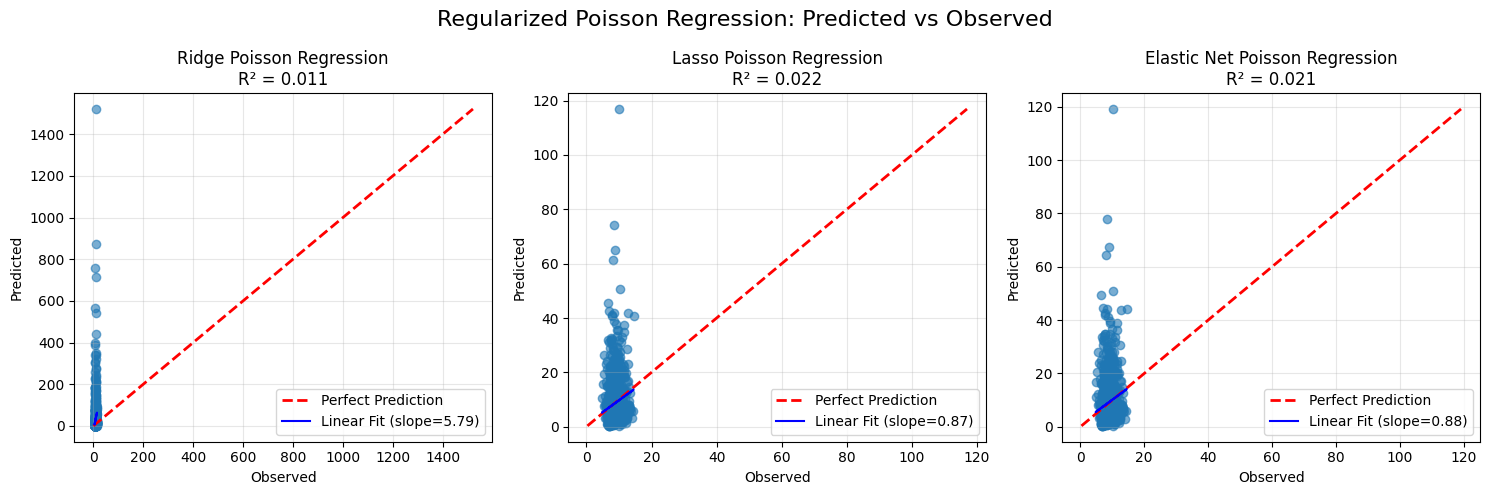

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for all three models
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Regularized Poisson Regression: Predicted vs Observed', fontsize=16)

models = [
    ('Ridge', y_pred_ridge_adjusted),
    ('Lasso', y_pred_lasso),
    ('Elastic Net', y_pred_elastic)
]

for i, (model_name, y_pred) in enumerate(models):
    ax = axes[i]

    # Scatter plot
    ax.scatter(y_test, y_pred, alpha=0.6)

    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    # Linear fit
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    ax.plot(y_test, p(y_test), "b-", label=f'Linear Fit (slope={z[0]:.2f})')

    # Calculate R² for the linear fit
    y_pred_fit = p(y_test)
    ss_res = np.sum((y_pred - y_pred_fit) ** 2)
    ss_tot = np.sum((y_pred - np.mean(y_pred)) ** 2)
    r2_fit = 1 - (ss_res / ss_tot)

    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{model_name} Poisson Regression\nR² = {r2_fit:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Advanced: Cross-Validation for Elastic Net Parameters

Performing Elastic Net cross-validation...
Best Elastic Net parameters:
  alpha: 0.001000
  l1_ratio: 0.90
  mean RMSE: 11.5409


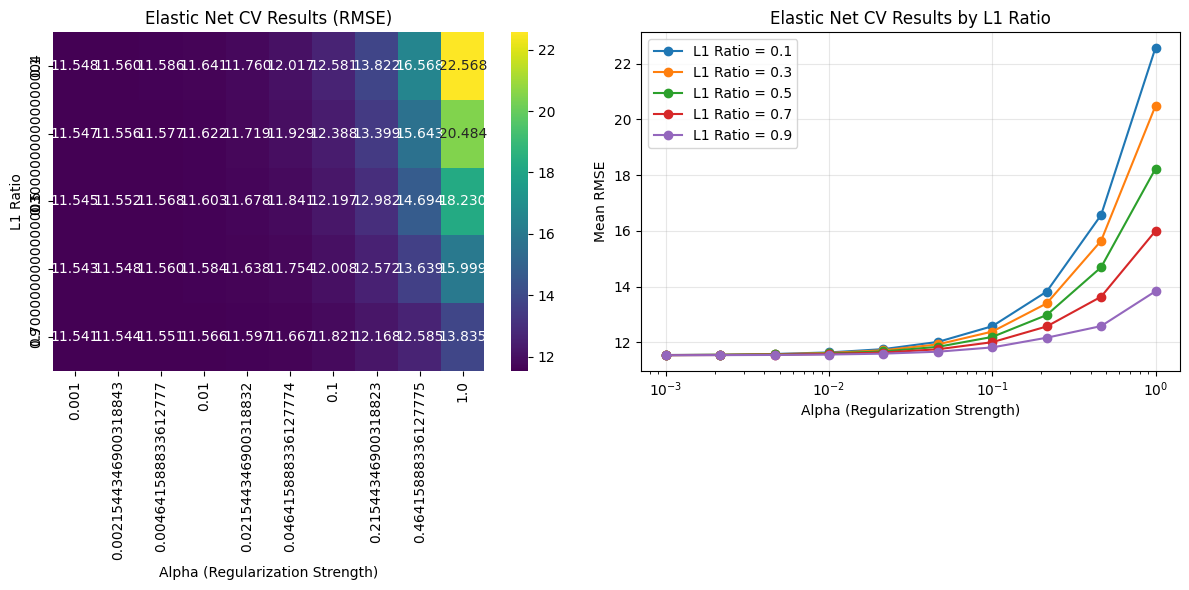

In [ ]:
from sklearn.model_selection import ParameterGrid

def elastic_net_cv(X, y, offset, alpha_values, l1_ratio_values, cv_folds=5):
    """Perform cross-validation for Elastic Net parameters"""
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    results = []

    param_grid = ParameterGrid({
        'alpha': alpha_values,
        'l1_ratio': l1_ratio_values
    })

    for params in param_grid:
        alpha = params['alpha']
        l1_ratio = params['l1_ratio']
        rmse_scores = []

        for train_idx, val_idx in kf.split(X):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            offset_train_fold, offset_val_fold = offset[train_idx], offset[val_idx]

            # Scale features
            scaler_fold = StandardScaler()
            X_train_fold_scaled = scaler_fold.fit_transform(X_train_fold[:, 1:])  # exclude constant
            X_val_fold_scaled = scaler_fold.transform(X_val_fold[:, 1:])

            # Add constant back
            X_train_fold_scaled_sm = sm.add_constant(X_train_fold_scaled)
            X_val_fold_scaled_sm = sm.add_constant(X_val_fold_scaled)

            try:
                # Fit model
                model = sm.GLM(
                    y_train_fold,
                    X_train_fold_scaled_sm,
                    family=sm.families.Poisson(),
                    offset=offset_train_fold
                ).fit_regularized(
                    method='elastic_net',
                    alpha=alpha,
                    L1_wt=l1_ratio,
                    maxiter=100
                )

                # Predict
                y_pred_fold = model.predict(X_val_fold_scaled_sm, offset=offset_val_fold)

                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
                rmse_scores.append(rmse)

            except Exception as e:
                # If model fails to converge, assign high RMSE
                rmse_scores.append(9999)

        mean_rmse = np.mean(rmse_scores)
        results.append({
            'alpha': alpha,
            'l1_ratio': l1_ratio,
            'mean_rmse': mean_rmse,
            'std_rmse': np.std(rmse_scores)
        })

    return pd.DataFrame(results)

# Define parameter grid
alpha_values = np.logspace(-3, 0, 10)  # 0.001 to 1
l1_ratio_values = np.linspace(0.1, 0.9, 5)  # 0.1 to 0.9

print("Performing Elastic Net cross-validation...")
cv_results_elastic = elastic_net_cv(
    X_train_scaled_sm,
    y_train.values,
    offset_train.values,
    alpha_values,
    l1_ratio_values
)

# Find best parameters
best_params = cv_results_elastic.loc[cv_results_elastic['mean_rmse'].idxmin()]
print(f"Best Elastic Net parameters:")
print(f"  alpha: {best_params['alpha']:.6f}")
print(f"  l1_ratio: {best_params['l1_ratio']:.2f}")
print(f"  mean RMSE: {best_params['mean_rmse']:.4f}")

# Plot results
plt.figure(figsize=(12, 6))

# Create pivot table for heatmap
pivot_table = cv_results_elastic.pivot(index='l1_ratio', columns='alpha', values='mean_rmse')

# Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='viridis')
plt.title('Elastic Net CV Results (RMSE)')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('L1 Ratio')

# Line plot for different L1 ratios
plt.subplot(1, 2, 2)
for l1_ratio in l1_ratio_values:
    subset = cv_results_elastic[cv_results_elastic['l1_ratio'] == l1_ratio]
    plt.plot(subset['alpha'], subset['mean_rmse'],
             marker='o', label=f'L1 Ratio = {l1_ratio:.1f}')

plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Mean RMSE')
plt.title('Elastic Net CV Results by L1 Ratio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')

plt.tight_layout()
plt.show()

## Feature Importance and Coefficient Analysis

Coefficient Comparison Across Models:
               Feature   Ridge   Lasso  Elastic Net
0                const  1.4762 -8.5657      -8.5216
1              Obesity  0.0157 -0.1337      -0.1625
2  Physical_Inactivity  0.0143  0.0858       0.1095
3     Access_Excercise  0.0003 -0.7151      -0.7075
4       Food_Env_Index -0.0213 -0.3194      -0.3306
5                  SVI  0.1347 -0.4350      -0.4527
6    Urban_Rural_Urban  0.0193 -0.5393      -0.5409


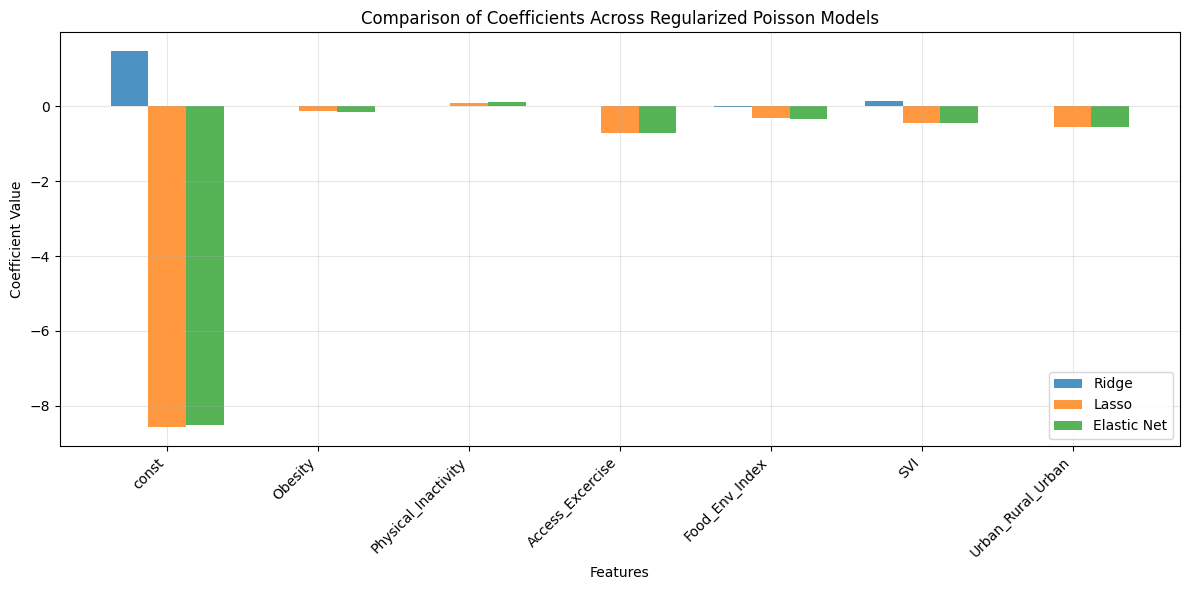


Important features (Lasso non-zero coefficients): ['const', 'Obesity', 'Physical_Inactivity', 'Access_Excercise', 'Food_Env_Index', 'SVI', 'Urban_Rural_Urban']


In [ ]:
# Compare coefficients across models
coef_comparison = pd.DataFrame({
    'Feature': feature_names_sm,
    'Ridge': [ridge_final.intercept_] + list(ridge_final.coef_),
    'Lasso': lasso_model.params.values,
    'Elastic Net': elastic_model.params.values
})

print("Coefficient Comparison Across Models:")
print(coef_comparison.round(4))

# Plot coefficients
plt.figure(figsize=(12, 6))

x = np.arange(len(feature_names_sm))
width = 0.25

plt.bar(x - width, coef_comparison['Ridge'], width, label='Ridge', alpha=0.8)
plt.bar(x, coef_comparison['Lasso'], width, label='Lasso', alpha=0.8)
plt.bar(x + width, coef_comparison['Elastic Net'], width, label='Elastic Net', alpha=0.8)

plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Comparison of Coefficients Across Regularized Poisson Models')
plt.xticks(x, feature_names_sm, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Identify important features (non-zero coefficients in Lasso)
important_features = coef_comparison[coef_comparison['Lasso'].abs() > 0.01]['Feature'].tolist()
print(f"\nImportant features (Lasso non-zero coefficients): {important_features}")

## Summary and Conclusion

In this tutorial, we explored the concept of Regularized Poisson Regression and its application for modeling count data in Python. The main objectives were to understand the theoretical foundations of regularization and implement it using both a manual approach and established Python libraries (`scikit-learn` and `statsmodels`).

### Key Takeaways:

1. **Poisson Regression**: Ideal for count data where the outcome follows a Poisson distribution.
2. **Offset**: Essential for adjusting for exposure variables like population size or time periods.
3. **Regularization**: Helps prevent overfitting and improves model generalization:
   - **Ridge (L2)**: Shrinks coefficients but rarely sets them to zero
   - **Lasso (L1)**: Can set coefficients to zero, enabling feature selection
   - **Elastic Net**: Combines L1 and L2 penalties for balanced performance

### Implementation Approaches:

1. **From Scratch**: We implemented gradient descent for regularized Poisson regression, which helps understand the underlying mathematics.
2. **scikit-learn**: Provides `PoissonRegressor` for Ridge-regularized Poisson models with excellent performance.
3. **statsmodels**: Offers more flexibility with `GLM.fit_regularized()` for Lasso and Elastic Net penalties.

### Practical Considerations:

- **Data Preprocessing**: Standardize features for better regularization performance
- **Cross-Validation**: Essential for selecting optimal regularization parameters
- **Model Evaluation**: Use appropriate metrics like RMSE, MAE, and R² for count data
- **Interpretation**: Regularized coefficients are more stable and interpretable than unregularized ones

By mastering the theoretical and practical aspects of regularized Poisson regression, you will be well-equipped to apply these techniques effectively across various contexts, from research to industry. Whether you are focused on predictive modeling, feature selection, or addressing overfitting, regularization offers robust solutions for analyzing count data.

## Resources

1. [scikit-learn Poisson Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html)
2. [statsmodels GLM Documentation](https://www.statsmodels.org/stable/glm.html)
3. [Poisson Regression in Python Tutorial](https://www.statsmodels.org/stable/examples/notebooks/generated/glm.html)
4. [Regularization in Machine Learning](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)
5. [Behavioral Risk Factor Surveillance System (BRFSS)](https://www.cdc.gov/brfss/)
6. [Food Environment Atlas](https://www.ers.usda.gov/data-products/food-environment-atlas.aspx)
7. [Diabetes Surveillance System](https://gis.cdc.gov/grasp/diabetes/diabetesatlas-surveillance.html)